This project is going to take the multichannel delay, apply the hadamard and check that the result is the same as Cipriani's FDN before attempting to optimize.

Credit to https://github.com/radoslawregula/reverb-algorithms/blob/master/fdn_prototype.pym for the damping filter and help with design.

In [1]:
import librosa
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display
import math
import soundfile as sf
import numpy.typing as npt
from numba import jit

In [2]:
%config InlineBackend.figure_formats = ['svg']
plt.style.use('dark_background')

In [3]:
SAMPLE_RATE = 44100

In [4]:
def feedforward_delay(x, loop_time=1, milliseconds=False):
    
    M = (loop_time / 1000) * SAMPLE_RATE if milliseconds else loop_time
    M = int(M) if (M > 0) else 1
    
    d = np.zeros(M) # wrap this buffer and add last value to input array.
    p = 0 # delay buffer index
    y = np.zeros(x.size) # output buffer
    
    for i in range(x.size):
        
        y[i] = d[p] 
        d[p] = x[i] # will not here the result until p reaches the beginning of the delay buffer d.
        p = p + 1 if (p < M-1) else 0
        
    return y

In [5]:
def prime(x, y):
    prime_list = []
    for i in range(x, y):
        if i == 0 or i == 1:
            continue
        else:
            for j in range(2, int(i/2)+1):
                if i % j == 0:
                    break
            else:
                prime_list.append(i)
    return prime_list

In [6]:
def del_list(n=16, min_dist=1., max_dist=100., curve=1, prime_list=np.array([0])):
    """
    create a list of delay times, with a minimum and maximum distance.
    
    n: number of delay times
    curve: exponential value to multiply each delay time by
    """
    
    # divided by speed of sound multiplied by milliseconds.
    min_dist  /= 344
    min_dist *= 1000.
    
    max_dist  /= 344.
    max_dist *= 1000.
    
    l = np.power(np.linspace(0, 1, n), curve)
    l = (((min_dist + (l * (max_dist - min_dist))) / 1000) * SAMPLE_RATE) + 0.5
    
    current = prime_list[(np.abs(prime_list - l[0])).argmin()]
    
    # check for index 0 or just start from 1 or something.
    
    for i in range(n):
        
        index = (np.abs(prime_list - l[i])).argmin()
        
        l[i] = prime_list[index]
        
        while (current >= l[i]):
            index += 1
            l[i] = prime_list[index]
        
        current = l[i]
    
    return l

1. create a unit impulse.
2. create a multichannel signal.
3. create a hadamard matrix
4. spread signal using hadamard.
5. delay signal with a feedback delay add to input signal
6. spread delayed signal, - Take output of this and sum not result of Hadammard! -
7. see how long it takes to build up recognisable echo density, try and automate.

In [7]:
def plot(x, title=None):
    x_axis = np.arange(0, x.shape[-1])
    fig = plt.figure()
    fig.suptitle(title)
    gs = fig.add_gridspec(x.shape[0], hspace=0.1)
    axs = gs.subplots(sharex=True, sharey=True)
    for i, ax in enumerate(axs):
        ax.plot(x_axis, x[i])
        ax.label_outer()

In [8]:
prime_list = prime(0, 30000)
l = del_list(n=4, curve=1.809, min_dist=1.0, max_dist=100, prime_list=prime_list)
l

array([  131.,  1867.,  6221., 12821.])

In [9]:
N = 4
x = np.zeros((N, 44100))
x[:, 0] = 1

In [10]:
# plot(x)

In [11]:
y = np.zeros(x.shape)

for i in range(x.shape[0]):
    y[i] = feedforward_delay(x[i], l[i])

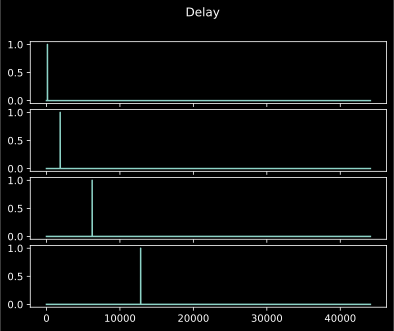

In [12]:
plot(y, "Delay")

In [13]:
H = scipy.linalg.hadamard(x.shape[0]) * 1 / x.shape[0]
H

array([[ 0.25,  0.25,  0.25,  0.25],
       [ 0.25, -0.25,  0.25, -0.25],
       [ 0.25,  0.25, -0.25, -0.25],
       [ 0.25, -0.25, -0.25,  0.25]])

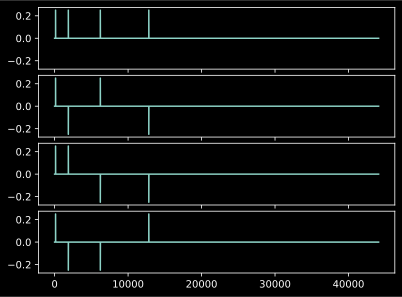

In [14]:
# this is more like it. but what happens when you sum the channels?
output = H @ y
plot(output)

In [15]:
# this is going to sum to zero, because there are delay's in the same place!
# but not if you delay again then sum?

# output = np.sum(m, axis=0)

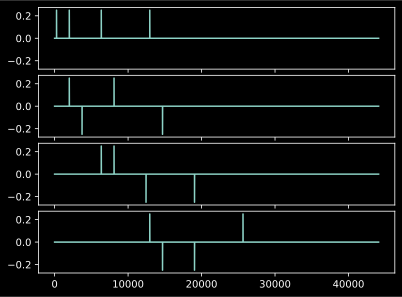

In [18]:
# take the sum here.
for i in range(x.shape[0]):
    y[i] = feedforward_delay(output[i], l[i])
plot(y)

In [19]:
def t60(duration_in_samples):
    return np.exp(np.log(0.001) / duration_in_samples)

In [48]:
def t60_time(multiplier):
    return np.log(0.001) / np.log(multiplier)

In [109]:
print(l)
decay_time = 1000
multiplier = t60(((decay_time/1000) * SAMPLE_RATE)/131)
time = t60_time(multiplier) * 131
time # this has to be larger.

[  131.   599.  3889. 12821.]


44100.00000000008

In [116]:
# calculate simple rt60 time.
# convert amplitude to decible, given a longest loop time of 100 how do we convert

def simple_fdn(input, decay, l, H):
    
    N = l.shape[0]
    # print(N)
    
    # empty array to calculate each t60 value.
    decay_ms = np.zeros(N)
    
    # print gain calculation for each delay line as a function of t60
    # convert ms to samples and then divide by loop_time in samples then take t60.
    for i in range(N):
        decay_ms[i] = t60(((decay/1000) * SAMPLE_RATE) / l[i])
    
    print(decay_ms)
    extra_time_in_samples = int(t60_time(decay_ms[-1]) * l[-1])
    print(extra_time_in_samples)
    
    x = np.zeros((N, input.shape[-1] + extra_time_in_samples))
    x[:, :input.shape[-1]] = input

    y = np.zeros(x.shape)
    output = np.zeros(x.shape)
    feedback = np.zeros(x.shape)
    feedback[:, :] = x[:, :]

    cnt = 0
    while True:
        for i in range(N):
            # print(feedback[i])
            y[i] = feedforward_delay(feedback[i] * decay_ms[i], l[i])
            output[i] += y[i]
        if np.array_equal(H @ y, feedback):
            break
        feedback = H @ y
        # if (cnt >= 16):
        #     break
        cnt += 1
    
    y = np.sum(output, axis=0)
    
    return y * (1 / np.max(np.abs(y)))

In [117]:
# unit impulse for testing.
x = np.zeros(SAMPLE_RATE)
x[0] = 1.0

In [118]:
N = 4
H = scipy.linalg.hadamard(N) * (2/N)
l = del_list(n=N, min_dist=1., max_dist=100., curve=3, prime_list=prime_list)
print(l)
y = simple_fdn(x, 1000.0, l, H)

[  131.   599.  3889. 12821.]
[0.99795014 0.99066124 0.94090162 0.81805464]
440999.9999999999


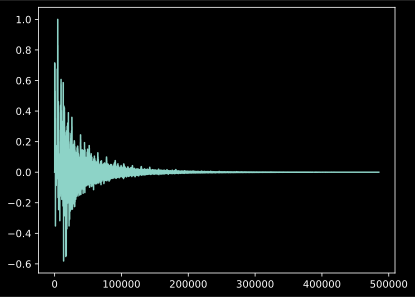

In [119]:
# plot(y)
plt.plot(y)
y.shape
Audio(y, rate=44100)

try and calculate the t60 time for the longest delay line.
you can probably now find the right code form Graham Wakefield's book and Geraint's code.

I need the time in samples that a signal X will take to reach 0.001 or -60dB given a delay length and an amplitude value.

In [106]:
print(l)

[  131.   599.  3889. 12821.]


In [25]:
# t60 = exp(log(0.001) / duration_in_samples)
# t60time = duration_in_samples = log(0.001)/log(multiplier)

In [28]:
# calculate decay in milliseconds as
# 100

decay_ms = t60((100 * SAMPLE_RATE) / l[0])
decay_ms

0.9997948246927055

In [27]:
# ok so take the values from l in samples and use to calculate t60 gain for each delay.
# rememeber min and max distance are room size, decay time is t60
# now use t60time to calculate the size of the buffer.